# Prelim

## Imports

*  "C1" = Cluster 1
*  "CP" = Cluster Prime Parameter
*  "FGM" = Flux Gate Magnetometer
*  "5VPS" = 5 vectors/second resolution
*  Skeleton table: https://spdf.gsfc.nasa.gov/pub/software/cdawlib/0SKELTABLES/c1_cp_fgm_5vps_00000000_v01.skt

In [4]:
import cdflib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from time import strftime, localtime
from datetime import datetime
import pandas as pd

In [5]:
# Naming the data of interest
data_name = "C1_CP_FGM_5VPS"
data_date_version = "20200201_000000_20200202_000000_V210607"
cdf_filename = data_name + "__" + data_date_version + ".cdf"
# Results in cdf_filename = "C1_CP_FGM_5VPS__20200201_000000_20200202_000000_V210607.cdf"
data_date = data_date_version[0:8]

In [6]:
cdf_file = cdflib.CDF(cdf_filename) # Extracts the data
cdf_file.cdf_info();# Gets the information of all the data stored in the CDF

## Extract Data

The EPOCH data type is used to store time values referenced from a particular epoch. For NSSDC applications that epoch is 01-Jan-0000 00:00:00.000.

In [9]:
cluster_epoch = cdf_file.varget("time_tags__C1_CP_FGM_5VPS") # extracts the time in milliseconds.
cluster_fgm = cdf_file.varget("B_vec_xyz_gse__C1_CP_FGM_5VPS") # extracts the fgm data

In [10]:
type(cluster_epoch)

numpy.ndarray

In [37]:
cluster_epoch

array([6.37477344e+13, 6.37477344e+13, 6.37477344e+13, ...,
       6.37478208e+13, 6.37478208e+13, 6.37478208e+13])

# Main

## Plotting

In [13]:
def vector_to_pandas(epoch_data, vector_data):
    """
    Function to convert list of epoch times and vectors into a pandas DataFrame.
    
    Parameters
    ----------
    epoch_data : numpy.ndarray (n_samples)
        Epoch times in milliseconds since 0 CE.
        
    vector_data : numpy.ndarray (n_samples, 3)
        Vector field components [x,y,z] at each epoch time.

    Returns
    -------
    pandas.DataFrame : with five columns :
        epoch : datetime : representation of the epoch time.
        x     : float    : x components of the vectors.
        y     : float    : y components of the vectors.
        z     : float    : z components of the vectors.
        mag   : float    : magnitudes of the vectors.
    
    """
    # Concerts epoch time (since 0 CE) into 'datetime'
    datetime_data = cdflib.cdfepoch.to_datetime(epoch_data)
    
    # Create a pandas dataFrame
    df = pd.DataFrame(vector_data, columns=['x', 'y', 'z'])

    # Add the epoch (time) column
    df['epoch'] = datetime_data
    
    # Add the magnitude column
    df['mag'] = np.linalg.norm(vector_data,axis=1)

    # Rearrange columns to have 'epoch' first
    df = df[['epoch', 'x', 'y', 'z', 'mag']]
    
    return df

In [14]:
df_fgm = vector_to_pandas(cluster_epoch, cluster_fgm) # fgm dataframe

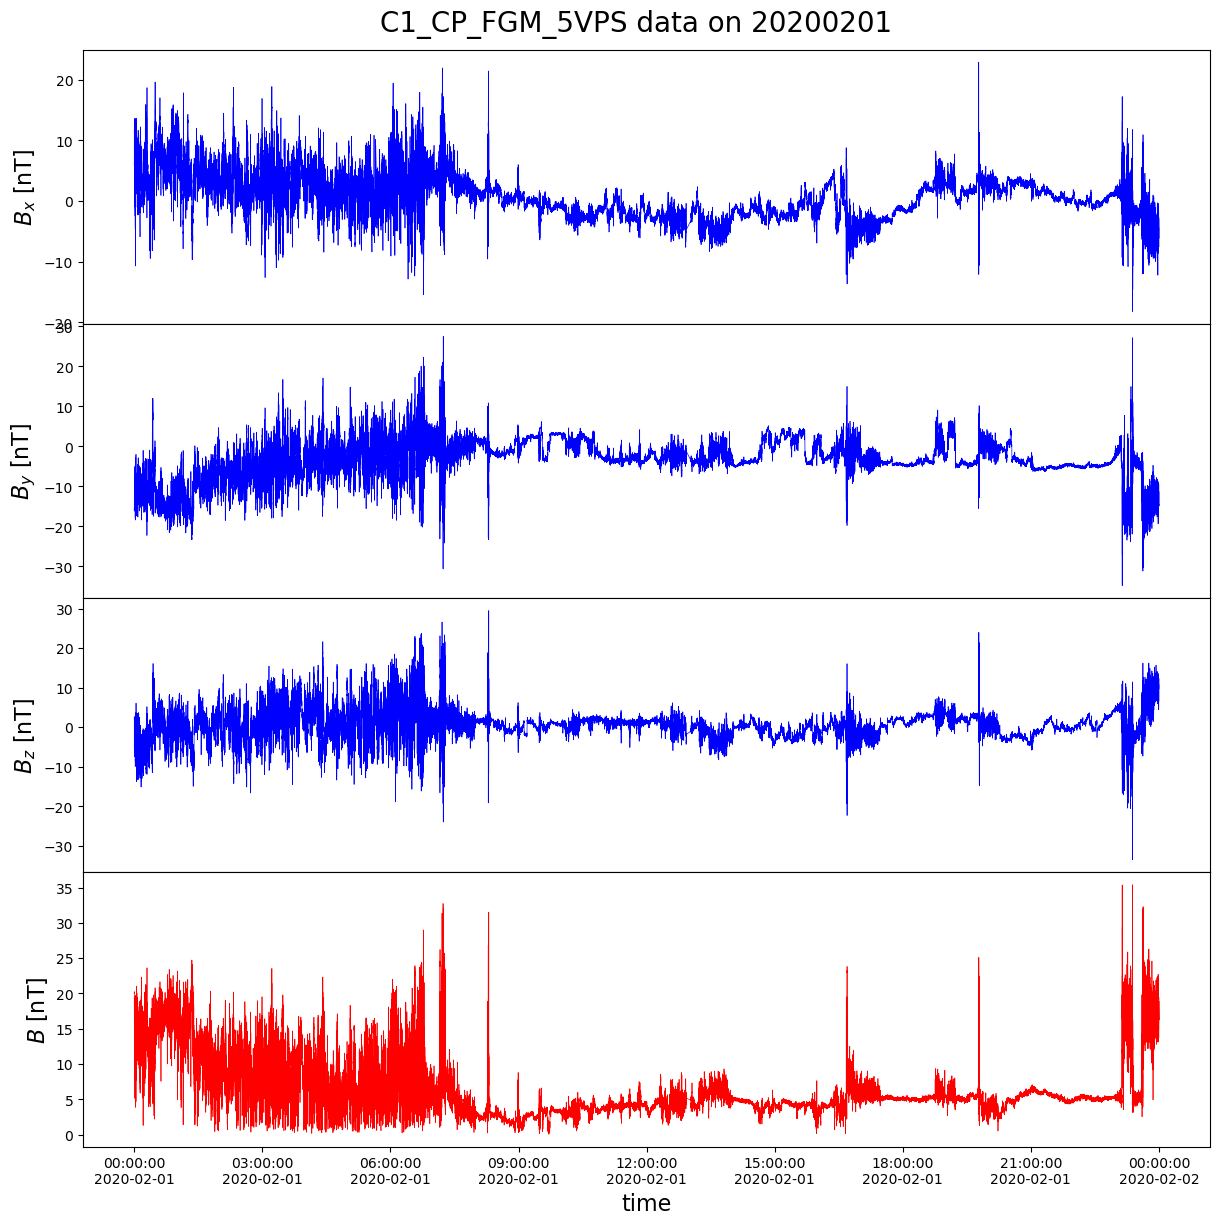

In [15]:
fig, axs = plt.subplots(4,  # 4 plots
                        figsize=(12,12), 
                        sharex=True, # share same x-range
                        sharey=False, # don't share same y-range
                        gridspec_kw={'hspace': 0})
fig.suptitle(f'{data_name} data on {data_date}', fontsize=20)

# Adjust the layout so that labels/titles don't overlap
plt.tight_layout()

# Plot B_x, B_y, and B_z against epoch on different axes
axs[0].plot(df_fgm['epoch'], df_fgm['x'], c='b', lw=0.5)
axs[1].plot(df_fgm['epoch'], df_fgm['y'], c='b', lw=0.5)
axs[2].plot(df_fgm['epoch'], df_fgm['z'], c='b', lw=0.5)
axs[3].plot(df_fgm['epoch'], df_fgm['mag'], c='r', lw=0.5)

# Add labels and title
plt.xlabel(r'time', fontsize=16) # or axs[2].set_xlabel

# Format the x-axis to display full dates and times with more detail
# "Hour:Minute:Second // Year-Month-Day"
date_format = mdates.DateFormatter('%H:%M:%S\n%Y-%m-%d')
axs[2].xaxis.set_major_formatter(date_format)

axs[0].set_ylabel(r'$B_x$ [nT]', fontsize=16)
axs[1].set_ylabel(r'$B_y$ [nT]', fontsize=16)
axs[2].set_ylabel(r'$B_z$ [nT]', fontsize=16)
axs[3].set_ylabel(r'$B$ [nT]', fontsize=16);

#plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')

## Rolling Averages

In [17]:
def rolling_averages(df, window_size=3600):
    """
    Function to add rolling averages to a pandas DataFrame.
    
    Parameters
    ----------
    pandas.DataFrame : with five columns :
        epoch : datetime : representation of the epoch time.
        x     : float    : x components of the vectors.
        y     : float    : y components of the vectors.
        z     : float    : z components of the vectors.
        mag   : float    : magnitudes of the vectors.
        
    window_size : int : optional :
        The number of consecutive data points to be averaged for the mean.
        The default is to average over 3600 data points,
        (assuming 1 data point a second, this equates to an hour window).

    Returns
    -------
    pandas.DataFrame : with four *more* columns :
        x_roll     : float    : rolling average of the x component.
        y_roll     : float    : rolling average of the y component.
        z_roll     : float    : rolling average of the z component.
        mag_roll   : float    : rolling average of the magnitude.
    
    """
    # For example, to calculate a rolling average over a time period of 1 hour by default
    df['x_roll'] = df['x'].rolling(window=window_size).mean()
    df['y_roll'] = df['y'].rolling(window=window_size).mean()
    df['z_roll'] = df['z'].rolling(window=window_size).mean()
    df['mag_roll'] = df['mag'].rolling(window=window_size).mean()

    return df

### 1 hour

In [19]:
# fgm dataframe with rolling averages, with a window size of 18000 points, (equates to 1 hour measuring 5 vectors a second)
window = 60 # minutes
window_size = window * 60 * 5 # number of minutes * 60 for number of seconds, and data is 5 vectors per second
df_fgm_rolling = rolling_averages(df_fgm, window_size)

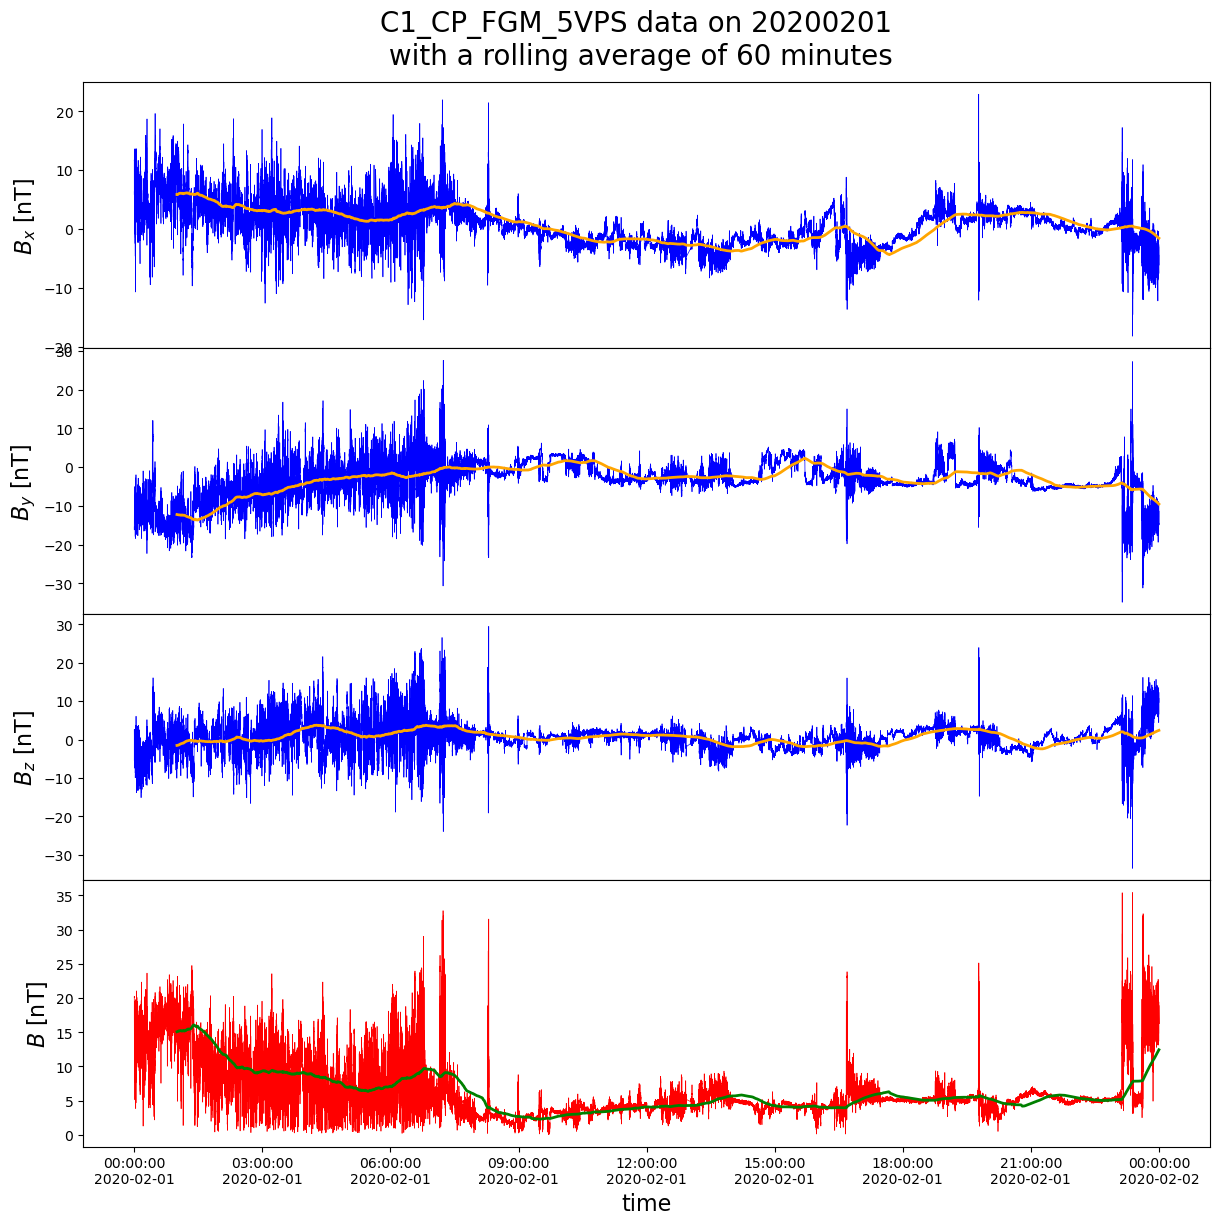

In [20]:
fig, axs = plt.subplots(4,  # 4 plots
                        figsize=(12,12), 
                        sharex=True, # share same x-range
                        sharey=False, # don't share same y-range
                        gridspec_kw={'hspace': 0})
fig.suptitle(f'{data_name} data on {data_date}\n with a rolling average of {window} minutes', fontsize=20)

# Adjust the layout so that labels/titles don't overlap
plt.tight_layout()

# Plot B_x, B_y, and B_z against epoch on different axes
axs[0].plot(df_fgm['epoch'], df_fgm['x'], c='b', lw=0.5)
axs[0].plot(df_fgm['epoch'], df_fgm['x_roll'], c='orange', lw=2)

axs[1].plot(df_fgm['epoch'], df_fgm['y'], c='b', lw=0.5)
axs[1].plot(df_fgm['epoch'], df_fgm['y_roll'], c='orange', lw=2)

axs[2].plot(df_fgm['epoch'], df_fgm['z'], c='b', lw=0.5)
axs[2].plot(df_fgm['epoch'], df_fgm['z_roll'], c='orange', lw=2)

axs[3].plot(df_fgm['epoch'], df_fgm['mag'], c='r', lw=0.5)
axs[3].plot(df_fgm['epoch'], df_fgm['mag_roll'], c='g', lw=2)

# Add labels and title
plt.xlabel(r'time', fontsize=16) # or axs[2].set_xlabel

# Format the x-axis to display full dates and times with more detail
# "Hour:Minute:Second // Year-Month-Day"
date_format = mdates.DateFormatter('%H:%M:%S\n%Y-%m-%d')
axs[2].xaxis.set_major_formatter(date_format)

axs[0].set_ylabel(r'$B_x$ [nT]', fontsize=16)
axs[1].set_ylabel(r'$B_y$ [nT]', fontsize=16)
axs[2].set_ylabel(r'$B_z$ [nT]', fontsize=16)
axs[3].set_ylabel(r'$B$ [nT]', fontsize=16);

#plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')

### 30 mins

In [22]:
# fgm dataframe with rolling averages, with a window size of 9000 points, (equates to 30 minutes)
window = 30 # minutes
window_size = window * 60 * 5
df_fgm_rolling = rolling_averages(df_fgm, window_size)

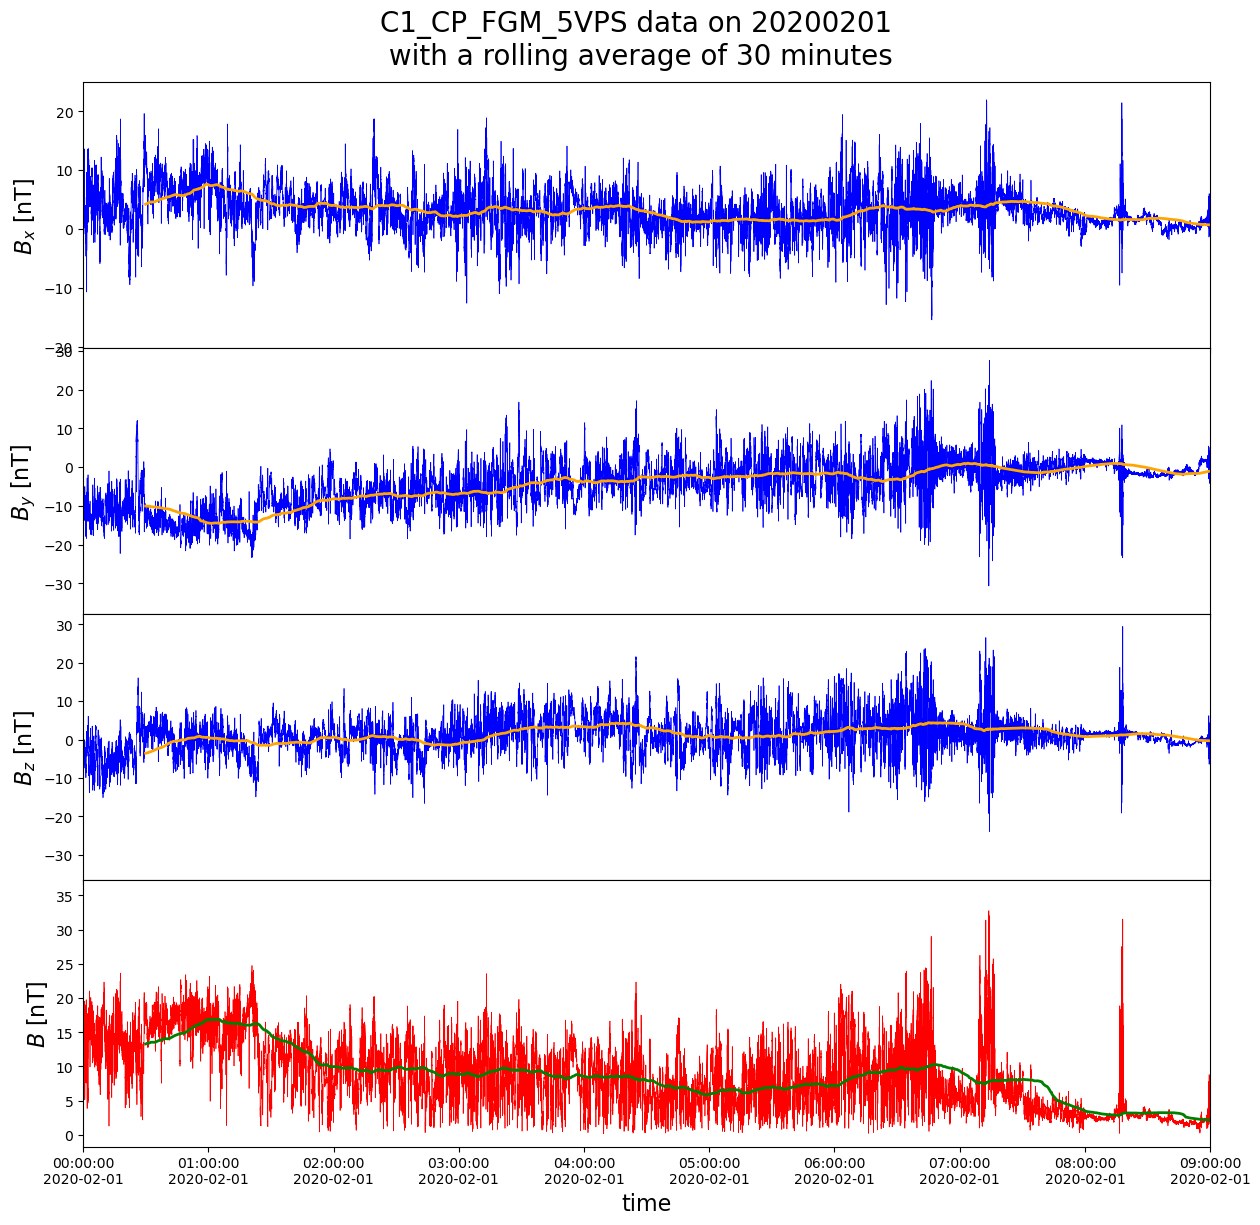

In [23]:
fig, axs = plt.subplots(4,  # 4 plots
                        figsize=(12,12), 
                        sharex=True, # share same x-range
                        sharey=False, # don't share same y-range
                        gridspec_kw={'hspace': 0})
fig.suptitle(f'{data_name} data on {data_date}\n with a rolling average of {window} minutes', fontsize=20)

# Adjust the layout so that labels/titles don't overlap
plt.tight_layout()

# Plot B_x, B_y, and B_z against epoch on different axes
axs[0].plot(df_fgm['epoch'], df_fgm['x'], c='b', lw=0.5)
axs[0].plot(df_fgm['epoch'], df_fgm['x_roll'], c='orange', lw=2)

axs[1].plot(df_fgm['epoch'], df_fgm['y'], c='b', lw=0.5)
axs[1].plot(df_fgm['epoch'], df_fgm['y_roll'], c='orange', lw=2)

axs[2].plot(df_fgm['epoch'], df_fgm['z'], c='b', lw=0.5)
axs[2].plot(df_fgm['epoch'], df_fgm['z_roll'], c='orange', lw=2)

axs[3].plot(df_fgm['epoch'], df_fgm['mag'], c='r', lw=0.5)
axs[3].plot(df_fgm['epoch'], df_fgm['mag_roll'], c='g', lw=2)

# Add labels and title
plt.xlabel(r'time', fontsize=16) # or axs[2].set_xlabel

# Set the x-axis limits to a specific time range
start_time = pd.to_datetime('2020-02-01 00:00:00')  # Adjust to your desired start time
end_time = pd.to_datetime('2020-02-01 09:00:00')    # Adjust to your desired end time

# Set the limits for the x-axis
plt.xlim(start_time, end_time)

# Format the x-axis to display full dates and times with more detail
# "Hour:Minute:Second // Year-Month-Day"
date_format = mdates.DateFormatter('%H:%M:%S\n%Y-%m-%d')
axs[2].xaxis.set_major_formatter(date_format)

axs[0].set_ylabel(r'$B_x$ [nT]', fontsize=16)
axs[1].set_ylabel(r'$B_y$ [nT]', fontsize=16)
axs[2].set_ylabel(r'$B_z$ [nT]', fontsize=16)
axs[3].set_ylabel(r'$B$ [nT]', fontsize=16);

#plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')